## 8.3 循环神经网络的变种
在以上几节中已经完整地介绍了使用LSTM 结构的循环神经网络。这一节将再介绍循环神经网络的几个常用变种以及它们所解决的问题，同时也会给出如何使用TensorFlow来实现这些变种。

### 8.3.1 双向循环神经网络和深层循环神经网络

**1. 双向循环神经网络**

在经典的循环神经网络中，状态的传输是从前往后单向的。然而，**在有些问题中，当前时刻的输出不仅和之前的状态有关系，也和之后的状态相关。这时就需要使用双向循环神经网络（bidirectional RNN）**来解决这类问题。例如预测一个语句中缺失的单词不仅需要根据前文来判断，也需要根据后面的内容，这时双向循环网络就可以发挥它的作用。双向循环神经网络是由两个独立的循环神经网络叠加在一起组成的。输出由这两个循环神经网络的输出拼接而成。下图展示了一个双向循环神经网络的结构图：
<p align='center'>
    <img src=images/图8.8.JPG>
</p>

从图8.8中可以看到，双向循环神经网络的主体结构就是两个单向循环神经网络的结合。**在每一个时刻t，输入会同时提供给这两个方向相反的循环神经网络。两个网络独立进行计算，各自产生该时刻的新状态和输出，而双向循环网络的最终输出是这两个单向循环神经网络的输出的简单拼接。**两个循环神经网络除方向不同以外，其余结构完全对称。每一层网络中的循环体可以自由选用任意结构，如前面介绍过的简单RNN、LSTM均可作为双向循环网络的循环体。双向循环神经网络的前向传播过程和单向的循环神经网络十分类似，这里不再赘述。更多关于双向神经网络的介绍可以参考Mike Schuster和Kuldip K. Paliwal发表的论文[Bidirectional recurrent neural networks](https://maxwell.ict.griffith.edu.au/spl/publications/papers/ieeesp97_schuster.pdf)。

**2. 深层循环神经网络**

深层循环神经网络（Deep RNN）是RNN的另外一种变种。**为了增强模型的表达能力，可以在网络中设置多个循环层，将每层循环网络的输出传给下一层进行处理**。在图8.2描述的单层循环网络中，每一时刻的输入$x_t$到输出$o_t$之间只有一个全连接层，因此在$x_t$到$o_t$的路径上是一个很浅的神经网络，从输入中提取抽象信息的能力将受到限制。图8.9给出了深层循环神经网络的结构示意图，可以看到，在一个L层的深层循环网络中，每一时刻的输入$x_t$到输出$o_t$之间有L个循环体，网络因此可以从输入中抽取更加高层的信息。**和CNN类似，每一层的循环体中参数是一致的，而不同层中的参数可以不同。**
<p align='center'>
    <img src=images/图8.9.JPG>
</p>

为了更好地支持深层循环神经网络，TensorFlow中提供了MultiRNNCell类来实现深层循环神经网络的前向传播过程。以下代码展示如何使用这个类：

In [ ]:
'''
# 定义一个基本的LSTM结构作为循环体的基础结构。Deep RNN也支持使用其他的循环体结构。
lstm_cell= tf.nn.rnn_cell.BasicLSTMCell

# 通过MultiRNNCell类实现深层循环神经网络中每一个时刻的前向传播过程。
# 其中number_of_layers表示有多少层，也就是图8.9中从xt到ht要经过多少个LSTM结构。
# 注意从TensorFlow1.1版本起，不能使用[lstm_cell(lstm_size)] * N 的形式来
# 初始化MultiRNNCell，否则TensorFlow会在每一层之间共享参致。
stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(lstm_size) for _ in range(number_of_layers)])
                
# 和经典的循环神经网络一样，可以通过zero_state函数来获取初始状态。
state = stacked_lstm.zero_state(batch size, tf.float32)

# 和8.2节中给出的代码一样，计算每一时刻的前向传播结果。
for i in range(len(num_steps)) :
    if i > 0: tf.get_variable_scope().reuse_variables()
    stacked_lstm_output, state = stacked_lstm(current_input, state)
    final_output = fully_connected(stacked_lstm_output)
    loss += calc_loss(final_output, expected_output)
'''

从以上代码可以看到，在TensorFlow中只需要在`BasicLSTMCell`的基础上再封装一层`MultiRNNCell`就可以非常容易地实现深层循环神经网络了。

### 8.3.2 循环神经网络的dropout
6.4节介绍过在CNN上使用dropout的方法，通过dropout可以让CNN更加健壮（robust）。类似的，在RNN中使用dropout也有同样的功能。而且，**类似CNN只在最后的全连接层中使用dropout，RNN一般只在不同层循环体结构之间使用dropout，而不在同一层的循环体结构之间使用。**也就是说从时刻t-1传递到时刻t时，RNN不会进行状态的dropout；而在同一个时刻t中，不同层循环体之间会使用dropout。

图8.9展示了RNN使用dropout的方法。假设要从t-2时刻的输入$x_{t-2}$传递到t+1时刻的输出$y_{t+1}$，那么$x_{t-2}$将首先传入第一层循环体结构，这个过程会使用dropout。但是从t-2时刻的第一层循环体结构传递到第一层的t-1、t、t+1时刻不会使用dropout。在t+1时刻的第一层循环体结构传递到同一时刻内更高层的循环体结构时，会再次使用dropout。
<p align='center'>
    <img src=images/图8.10.JPG>
</p>

在Tensorflow中，使用`tf.nn.rnn_cell.DropoutWrapper`类可以很容易实现dropout功能。以下代码展示了如何在TensoFlow中实现带dropout的RNN:

In [ ]:
'''
# 定义LSTM结构。
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell

# 使用DropoutWrapper类来实现dropout 功能。该类通过两个参数来控制dropout的概率，
#   一个参数为input_keep_prob，它可以用来控制输入的dropout概率；
#   另一参数为output_keep_prob，它可以用来控制输出的dropout概率。
# 在使用了DropoutWrapper的基础上定义MultiRNNCell。
stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(
              [tf.nn.rnn_cell.DropoutWrapper(lstm_cell(lstm_size))
              for _ in range(number_of_layers)])

# 和8.3.1节中深层循环网络样例程序类似，运行前向传播过程。
'''

## 8.4 循环神经网络样例程序
在以上几节中已经介绍了不同RNN的网络结构，并给出了具体的TensorFlow程序来实现这些RNN的前向传播过程。这一节将以时序预测为例，利用RNN实现对函数$sin(x)$取值的预测。图8.11给出了$sin$函数的函数图像。
<p align='center'>
    <img src=images/图8.11.JPG>
</p>

下面的篇幅将给出具体的TensorFlow程序来实现预测正弦函数$sin$。因为RNN模型预测的是离散时刻的取值，所以在程序中需要将连续的$sin$函数曲线离散化。所谓离散化就是在一个给定的区间[0, MAX]内，通过有限个采样点模拟一个连续的曲线。比如在以下程序中每隔SAMPLE_ITERVAL对$sin$函数进行一次来样，采样得到的序列就是$sin$函数离散化之后的结果。以下程序为预测离散化之后的$sin$函数:

train step: 0, loss:  0.4196214
train step: 1000, loss:  0.0010739247
train step: 2000, loss:  0.0002879769
train step: 3000, loss:  5.4690085e-05
train step: 4000, loss:  1.3475828e-05
train step: 5000, loss:  4.33033e-06
train step: 6000, loss:  5.110061e-06
train step: 7000, loss:  4.500361e-06
train step: 8000, loss:  3.534146e-06
train step: 9000, loss:  3.5462117e-06
Root Mean Square Error is: 0.002050


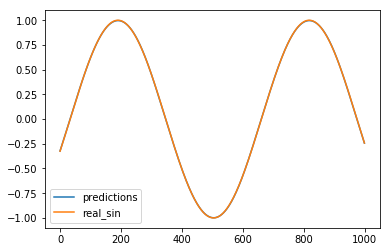

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 定义RNN的参数
HIDDEN_SIZE = 30                            # LSTM中隐藏节点的个数。
NUM_LAYERS = 2                              # LSTM的层数。
TIMESTEPS = 10                              # 循环神经网络的训练序列长度。
TRAINING_STEPS = 10000                      # 训练轮数。
BATCH_SIZE = 32                             # batch大小。
TRAINING_EXAMPLES = 10000                   # 训练数据个数。
TESTING_EXAMPLES = 1000                     # 测试数据个数。
SAMPLE_GAP = 0.01                           # 采样间隔。


# 2. 产生正弦数据函数
def generate_data(seq):
    X = []
    y = []
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入；第i + TIMESTEPS项作为输出。
    # 即用sin函数前面的TIMESTEPS个点的信息，预测第i + TIMESTEPS个点的函数值。
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  


# 3. 定义网络结构和优化步骤
def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构。
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.LSTMCell(HIDDEN_SIZE)
        for _ in range(NUM_LAYERS)]) 

    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果。
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    # outputs是顶层LSTM在每一步的输出结果，它的维度是[batch_size, time ,
    # HIDDEN_SIZE]。在本问题中只关注最后一个时刻的输出结果。
    output = outputs[:, -1, :]

    # 对LSTM网络的输出再做加一层全链接层并计算损失。注意这里默认的损失为平均
    # 平方差损失函数。
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果。
    if not is_training:
        return predictions, None, None
        
    # 计算损失函数。
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)
    
    return predictions, loss, train_op


# 4. 定义训练方法
def train(sess, train_X, train_Y):
    # 将训练数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 定义模型，得到预测结果、损失函数，和训练操作。
    with tf.variable_scope("model"):
        _, loss, train_op = lstm_model(X, y, True)
        
    sess.run(tf.global_variables_initializer())
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 1000 == 0:
            print("train step: " + str(i) + ", loss: ", str(l))
            

# 5. 定义测试方法
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    # 对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()
    
    
# 6. 生成数据并训练、验证
# 用正弦函数生成训练和测试数据集合。
# numpy.linspace函数可以创建一个等差序列的数组，它常用的参数有三个参数，
# 第一个参数表示起始值，第二个参数表示终止值，第三个参数表示数列的长度。
# 例如linespace(1, 10, 10)产生的数组是arrray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

with tf.Session() as sess:
    train(sess, train_X, train_y)
    run_eval(sess, test_X, test_y)

可以看到，预测得到的结果和真实的$sin$函数几乎是重合的，也就是说通过RNN可以非常好地预测$sin$函数的取值。